In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# TensorFlow and tf.keras
# import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [5]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [11]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [12]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


# Input Normalization

In [13]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [14]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
ds_info.features["label"].num_classes

10

In [16]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

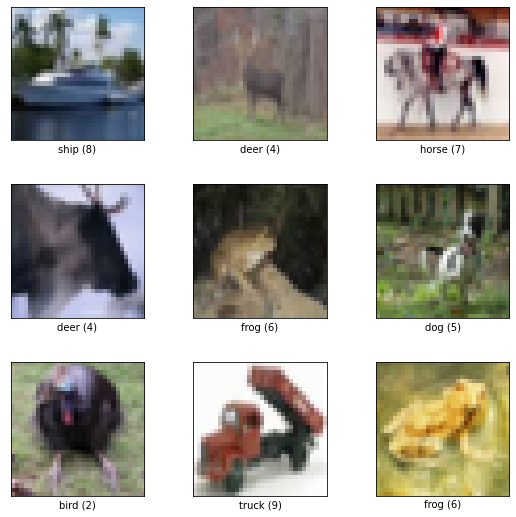

In [17]:
fig = tfds.show_examples(ds_train, ds_info)

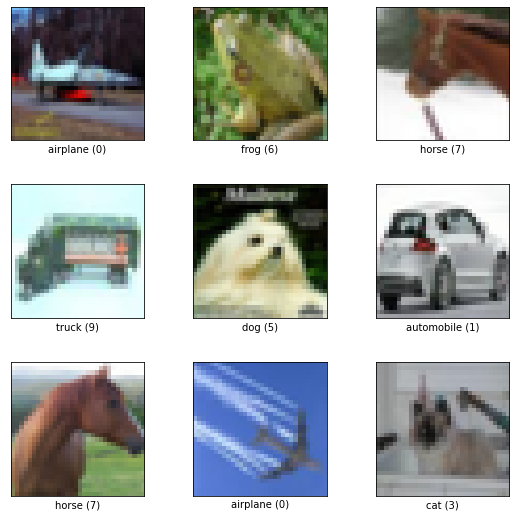

In [18]:
fig = tfds.show_examples(ds_test, ds_info)

# VGG 기본 블록 만들기

In [19]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [20]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [21]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


# VGG-16

In [22]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [23]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

# VGG-19

In [24]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

# CIFAR-10 데이터셋 학습 (VGG-16, VGG-19)

In [25]:
BATCH_SIZE = 256
EPOCH = 20

In [26]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [27]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 52s 266ms/step - loss: 2.1719 - accuracy: 0.1989 - val_loss: 2.0721 - val_accuracy: 0.2300
Epoch 2/20
195/195 [==============================] - 32s 165ms/step - loss: 1.9859 - accuracy: 0.2811 - val_loss: 1.9136 - val_accuracy: 0.3261
Epoch 3/20
195/195 [==============================] - 19s 98ms/step - loss: 1.8461 - accuracy: 0.3377 - val_loss: 1.7582 - val_accuracy: 0.3570
Epoch 4/20
195/195 [==============================] - 19s 98ms/step - loss: 1.7327 - accuracy: 0.3815 - val_loss: 1.7238 - val_accuracy: 0.3737
Epoch 5/20
195/195 [==============================] - 19s 98ms/step - loss: 1.6512 - accuracy: 0.4091 - val_loss: 1.6060 - val_accuracy: 0.4156
Epoch 6/20
195/195 [==============================] - 19s 99ms/step - loss: 1.5841 - accuracy: 0.4282 - val_loss: 1.5388 - val_accuracy: 0.4357
Epoch 7/20
195/195 [==============================] - 19s 96ms/step - loss: 1.5349 - accuracy: 0.4524 - val_loss: 1.5482 - val_accurac

In [28]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 22s 111ms/step - loss: 2.2154 - accuracy: 0.1682 - val_loss: 2.1310 - val_accuracy: 0.2343
Epoch 2/20
195/195 [==============================] - 21s 110ms/step - loss: 2.0545 - accuracy: 0.2438 - val_loss: 1.9454 - val_accuracy: 0.2960
Epoch 3/20
195/195 [==============================] - 22s 111ms/step - loss: 1.9231 - accuracy: 0.3020 - val_loss: 1.8717 - val_accuracy: 0.3307
Epoch 4/20
195/195 [==============================] - 22s 114ms/step - loss: 1.7895 - accuracy: 0.3559 - val_loss: 1.7064 - val_accuracy: 0.3988
Epoch 5/20
195/195 [==============================] - 22s 114ms/step - loss: 1.6894 - accuracy: 0.3892 - val_loss: 1.6363 - val_accuracy: 0.4241
Epoch 6/20
195/195 [==============================] - 22s 114ms/step - loss: 1.6230 - accuracy: 0.4133 - val_loss: 1.5785 - val_accuracy: 0.4314
Epoch 7/20
195/195 [==============================] - 21s 109ms/step - loss: 1.5710 - accuracy: 0.4356 - val_loss: 1.5328 - val_ac

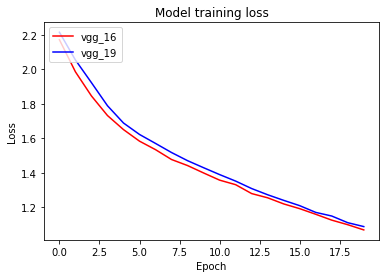

In [29]:
plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

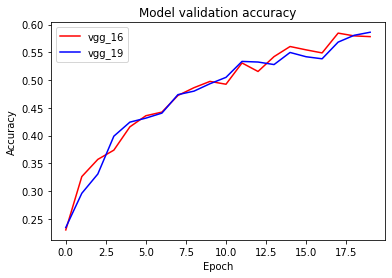

In [30]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# ResNet 기본 블록 구성

- ResNet-34

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D, Add, Activation, BatchNormalization, Dropout

In [7]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding='same', strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
        
    return x

def bottleneck_identity(input_tensor, filter_sizes, strides=1):
    filter_1, filter_2 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (3, 3), strides=strides)
    x = conv2d_bn(x, filter_2, (3, 3), activation=None)
    
    shortcut = Add()([input_tensor, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

def bottleneck_projection(input_tensor, filter_sizes, strides=2):
    filter_1, filter_2 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (3, 3), strides=strides)
    x = conv2d_bn(x, filter_2, (3, 3), activation=None)
    
    projected_input = conv2d_bn(input_tensor, filter_2, (1, 1), strides=strides, activation=None)
    shortcut = Add()([projected_input, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

In [11]:
inputs = Input(shape=(32, 32, 3))
x = conv2d_bn(inputs, 64, (7, 7), strides=2, padding='same')
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = bottleneck_projection(x, [64, 64], strides=1)
x = bottleneck_identity(x, [64, 64])
x = bottleneck_identity(x, [64, 64])

x = bottleneck_projection(x, [128, 128])
x = bottleneck_identity(x, [128, 128])
x = bottleneck_identity(x, [128, 128])
x = bottleneck_identity(x, [128, 128])

x = bottleneck_projection(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
    
x = bottleneck_projection(x, [512, 512])
x = bottleneck_identity(x, [512, 512])
x = bottleneck_identity(x, [512, 512])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# x = Dropout(0.5)(x)

model_output = Dense(10, activation='sigmoid', kernel_initializer='he_normal')(x) # 'softmax'

resnet34 = Model(inputs=inputs, outputs=model_output, name='ResNet34')

In [12]:
resnet34.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 16, 16, 64)   256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_37[0][0]     
___________________________________________________________________________________________

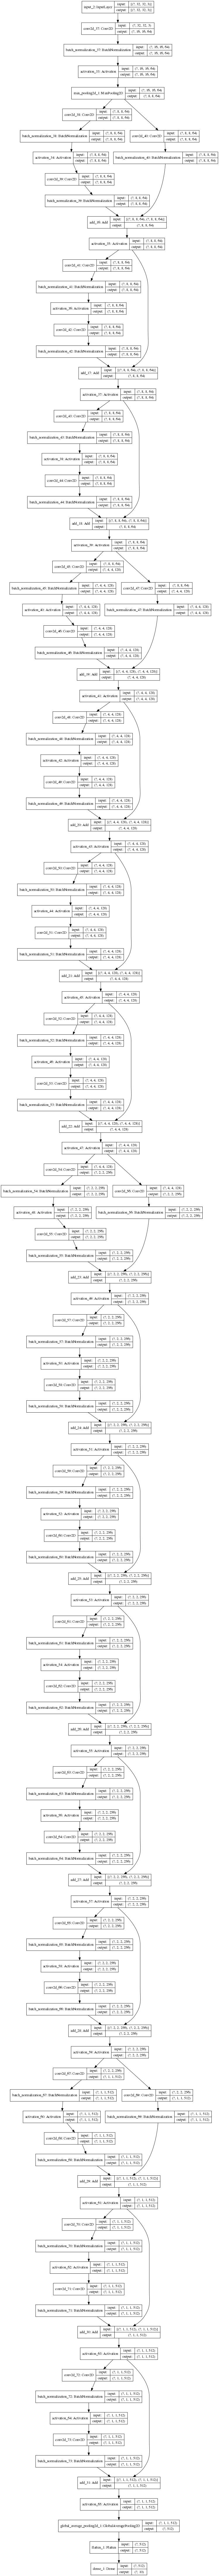

In [13]:
tf.keras.utils.plot_model(resnet34, show_shapes=True, dpi=64)

- ResNet-50

In [14]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

def bottleneck_identity(input_tensor, filter_sizes):
    filter_1, filter_2, filter_3 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (1, 1))
    x = conv2d_bn(x, filter_2, (3, 3))
    x = conv2d_bn(x, filter_3, (1, 1), activation=None)
    
    shortcut = Add()([input_tensor, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

def bottleneck_projection(input_tensor, filter_sizes, strides=2):
    filter_1, filter_2, filter_3 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (1, 1), strides=strides)
    x = conv2d_bn(x, filter_2, (3, 3))
    x = conv2d_bn(x, filter_3, (1, 1), activation=None)
    
    projected_input = conv2d_bn(input_tensor, filter_3, (1, 1), strides=strides, activation=None)
    shortcut = Add()([projected_input, x])
    shortcut = Activation(activation='relu')(shortcut)
    
    return shortcut

In [16]:

inputs = Input(shape=(32, 32, 3))
x = conv2d_bn(inputs, 64, (7, 7), strides=2, padding='same')
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = bottleneck_projection(x, [64, 64, 256], strides=1)
x = bottleneck_identity(x, [64, 64, 256])
x = bottleneck_identity(x, [64, 64, 256])

x = bottleneck_projection(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])

x = bottleneck_projection(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
    
x = bottleneck_projection(x, [512, 512, 2048])
x = bottleneck_identity(x, [512, 512, 2048])
x = bottleneck_identity(x, [512, 512, 2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# x = Dropout(0.5)(x)

model_output = Dense(10, activation='sigmoid', kernel_initializer='he_normal')(x) # 'softmax'

resnet50 = Model(inputs=inputs, outputs=model_output, name='ResNet50')

In [17]:
resnet50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 16, 16, 64)   9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_127 (BatchN (None, 16, 16, 64)   256         conv2d_127[0][0]                 
__________________________________________________________________________________________________
activation_115 (Activation)     (None, 16, 16, 64)   0           batch_normalization_127[0][0]    
___________________________________________________________________________________________

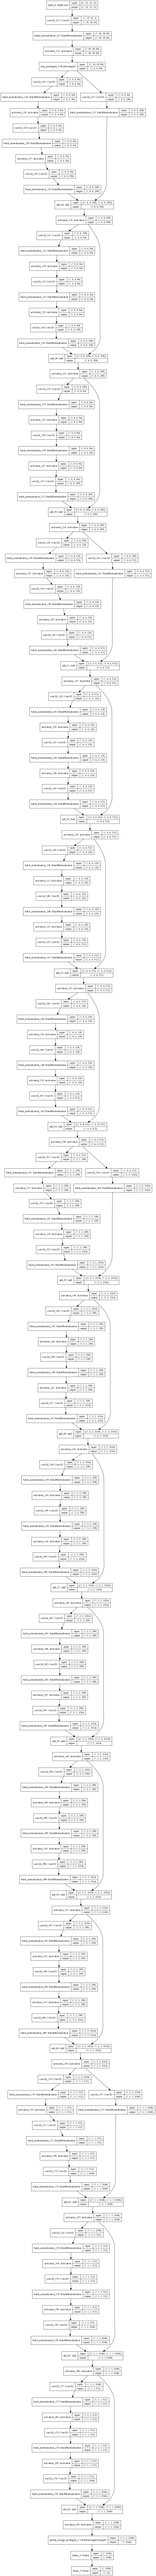

In [19]:
tf.keras.utils.plot_model(resnet50, show_shapes=True, dpi=64)

# Plain Network (34-layer, 50-layer)

In [28]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding='same', strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
        
    return x

def bottleneck_identity(input_tensor, filter_sizes, strides=1):
    filter_1, filter_2 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (3, 3), strides=strides)
    x = conv2d_bn(x, filter_2, (3, 3), activation=None)
    
    # shortcut = Add()([input_tensor, x])
    x = Activation(activation='relu')(x)
    
    return x

def bottleneck_projection(input_tensor, filter_sizes, strides=2):
    filter_1, filter_2 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (3, 3), strides=strides)
    x = conv2d_bn(x, filter_2, (3, 3), activation=None)
    
    # projected_input = conv2d_bn(input_tensor, filter_2, (1, 1), strides=strides, activation=None)
    # shortcut = Add()([projected_input, x])
    x = Activation(activation='relu')(x)
    
    return x

In [29]:
inputs = Input(shape=(224, 224, 3))
x = conv2d_bn(inputs, 64, (7, 7), strides=2, padding='same')
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = bottleneck_projection(x, [64, 64], strides=1)
x = bottleneck_identity(x, [64, 64])
x = bottleneck_identity(x, [64, 64])

x = bottleneck_projection(x, [128, 128])
x = bottleneck_identity(x, [128, 128])
x = bottleneck_identity(x, [128, 128])
x = bottleneck_identity(x, [128, 128])

x = bottleneck_projection(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
x = bottleneck_identity(x, [256, 256])
    
x = bottleneck_projection(x, [512, 512])
x = bottleneck_identity(x, [512, 512])
x = bottleneck_identity(x, [512, 512])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# x = Dropout(0.5)(x)

model_output = Dense(10, activation='sigmoid', kernel_initializer='he_normal')(x) # 'softmax'

plain34 = Model(inputs=inputs, outputs=model_output, name='34-layer plain')

In [30]:
plain34.summary()

Model: "34-layer plain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_264 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_248 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_265 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_265 (Bat (None, 56, 56, 64)     

In [24]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size, kernel_initializer='he_normal', padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    return x

def bottleneck_identity(input_tensor, filter_sizes):
    filter_1, filter_2, filter_3 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (1, 1))
    x = conv2d_bn(x, filter_2, (3, 3))
    x = conv2d_bn(x, filter_3, (1, 1), activation=None)
    
    # shortcut = Add()([input_tensor, x])
    x = Activation(activation='relu')(x)
    
    return x

def bottleneck_projection(input_tensor, filter_sizes, strides=2):
    filter_1, filter_2, filter_3 = filter_sizes
    
    x = conv2d_bn(input_tensor, filter_1, (1, 1), strides=strides)
    x = conv2d_bn(x, filter_2, (3, 3))
    x = conv2d_bn(x, filter_3, (1, 1), activation=None)
    
    # projected_input = conv2d_bn(input_tensor, filter_3, (1, 1), strides=strides, activation=None)
    # shortcut = Add()([projected_input, x])
    x = Activation(activation='relu')(x)
    
    return x

In [25]:

inputs = Input(shape=(224, 224, 3))
x = conv2d_bn(inputs, 64, (7, 7), strides=2, padding='same')
x = MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = bottleneck_projection(x, [64, 64, 256], strides=1)
x = bottleneck_identity(x, [64, 64, 256])
x = bottleneck_identity(x, [64, 64, 256])

x = bottleneck_projection(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])
x = bottleneck_identity(x, [128, 128, 512])

x = bottleneck_projection(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
x = bottleneck_identity(x, [256, 256, 1024])
    
x = bottleneck_projection(x, [512, 512, 2048])
x = bottleneck_identity(x, [512, 512, 2048])
x = bottleneck_identity(x, [512, 512, 2048])

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
# x = Dropout(0.5)(x)

model_output = Dense(10, activation='sigmoid', kernel_initializer='he_normal')(x) # 'softmax'

plain50 = Model(inputs=inputs, outputs=model_output, name='50-layer plain')

In [26]:
plain50.summary()

Model: "50-layer plain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_214 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_198 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_215 (Bat (None, 56, 56, 64)     